In [29]:
# get a 2d simulation domain (sim  0 idx 35 looks promising) x
# get 1d slices associated with that 2d sim domain x
# get model used in ESS paper (use import_model probly?) x
# find and display plasmoids
# use model on 1d slices to predict plasmoids x
# green dots? for correct IDs
# red dots/xes? for false IDS

In [30]:
import sys
sys.path.append('/tigress/kendrab/python_pkgs')

import numpy as np
from dataframework.src.datasets.vpicdataset import VPICDataset
import h5py
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
from  torch.nn.functional import one_hot
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
from matplotlib.gridspec import GridSpec
device = "cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu"
print(f"Using {device} device")
dtype = torch.double
   
# Get functions from other notebooks
%run /tigress/kendrab/analysis-notebooks/preproc_utils.ipynb
%run /tigress/kendrab/analysis-notebooks/eval_utils.ipynb

Using cpu device


In [31]:
def mtail_transform(sim_data):  # TODO FIX THIS  # From 1d_sampling notebook
    """ The geometry of the simulation is different wrt the magnetotail. Keeping y the same, bx will be
    the mtail's 'bz' and bz will be the mtails 'bx'.
    This function is for simulations WITHOUT y spatial dimensions
    THIS IS NOT A GOOD GENERALIZABLE FUNCTION!!!! REUSE WITH EXTREME CAUTION!!!
    This is for rxn geometry in vpic with Bz positive for x>0 and negative for x<0.
    If it is the opposite, need to do a different transform to get the reconnection to line up w/ gsm directions
    """
    # vpic +x -> GSM +z
    # vpic +z -> GSM +x
    # vpic +y -> GSM -y
    # meshes now in order x, z instead of z, x (renaming coords)
    # for vector variables ax, ay, az:
    # rename ax -> az_mms
    # ay_mms = -ay
    # rename az -> ax_mms
    sim_data.variables['bz_mms'] = sim_data.variables.pop('bx')
    sim_data.variables['bz_mms_smooth'] = sim_data.variables.pop('bx_smooth')
    sim_data.variables['by_mms'] = sim_data.variables.pop('by')
    sim_data.variables['by_mms'].data *= -1
    sim_data.variables['bx_mms'] = sim_data.variables.pop('bz') 
    sim_data.variables['bx_mms_smooth'] = sim_data.variables.pop('bz_smooth') 
    sim_data.variables['vx_mms'] = sim_data.variables.pop('vz')
    sim_data.variables['jy_mms'] = sim_data.variables.pop('jy')
    sim_data.variables['jy_mms'].data *= -1    
    sim_data.variables['ez_mms'] = sim_data.variables.pop('ex')
    sim_data.variables['ey_mms'] = sim_data.variables.pop('ey')
    sim_data.variables['ey_mms'].data *= -1
    sim_data.variables['ex_mms'] = sim_data.variables.pop('ez') 
    
    # update variable names for everyone
    for key in sim_data.variables.keys():
        print(f"label {sim_data.variables[key].label} becoming {key}")
        sim_data.variables[key].label = key

### Get the 2D data from original vpic datafile

In [32]:
file_num = 6  # so it is part of the testing dataset
file = f'/scratch/gpfs/kendrab/dataset_vpic_runs/perturbed/21032023/output{file_num}/data.h5'
writepath = '/tigress/kendrab/analysis-notebooks/model_outs/26-04-24/results_pics_E151952'

zooms = [[-np.inf,np.inf], [-20, 20]]
time_idx = 45 #the time index we are processing rn
kwargs = {'get_vars' : ['bx','by','bz','jy','vz','ex','ey','ez']}

In [33]:
sim_dset = VPICDataset(vpicfiles=[file,''], **kwargs)
desired_time = sim_dset.timeseries[time_idx]
dt = sim_dset.timeseries[1] - sim_dset.timeseries[0]
onetime_dset = sim_dset.ndslice(timelims=[desired_time - dt/2, desired_time + dt/2])
onetime_dset.find_structures(b1_name='bz', b2_name='bx', wrap=True)
zoomed_dset = onetime_dset.ndslice(zooms=zooms)
mtail_transform(zoomed_dset)

NO PARAMS ADDED, FUNCTIONALIITY NOT ADDED YET!!!! SORRY
parameter filename = /scratch/gpfs/kendrab/dataset_vpic_runs/perturbed/21032023/output6/data.h5
Added bx Variable
Added by Variable
Added bz Variable
Added jy Variable
Added vz Variable
Added ex Variable
Added ey Variable
Added ez Variable
Finding structures at simulation time 44.98957061767578
parameter d_per_de = 4
Added bz_smooth Variable
Added bx_smooth Variable
Added flux_fn Variable
Number of nulls:  14
parameter x_coords = [[1365.4250743   560.00112635]
 [1097.70480265  552.62166338]
 [1661.89501707  553.55864281]
 [1856.25897625  549.46355193]
 [2805.35264902  552.58316736]
 [3562.21601166  531.92172715]
 [3936.1979735   536.55393551]]
parameter o_coords = [[1239.94661566  556.00324476]
 [1560.21297229  559.12090978]
 [1815.24708761  552.97338692]
 [2267.75259712  565.42861952]
 [3396.10040599  548.15896207]
 [3790.26702707  538.12686565]
 [4292.94377269  561.00361058]]
Added fluxfn_hessian_det Variable
Added separatrices 

### Get 1D data from new file

In [34]:
oned_path = f"/tigress/kendrab/21032023/{file_num}/new_better/100samples_idx{time_idx}_bxbybzjyvzexeyez.hdf5"
padding_length = 10  # amount of data on each side of each segment for additional info
stride = 10  # size (and therefore spacing) of each segment
input_length = stride + 2*padding_length
batch_size = 256

with h5py.File(oned_path, 'r') as oned_file:
    s_list = list(oned_file['s'][:])
    bx_list = list(oned_file['bx_mms_smooth'][:])
    by_list = list(oned_file['by_mms'][:])
    bz_list = list(oned_file['bz_mms_smooth'][:])
    ex_list = list(oned_file['ex_mms'][:])
    ey_list = list(oned_file['ey_mms'][:])
    ez_list = list(oned_file['ez_mms'][:])
    jy_list = list(oned_file['jy_mms'][:])
    vx_list = list(oned_file['vx_mms'][:])  # vx_mms is simulation vx  thus the filename 
    x0_list = list(oned_file['x_mms'][:])
    x1_list = list(oned_file['z_mms'][:])
    topo_list_tmp = list(oned_file['topo'][:])
    for i in range(len(topo_list_tmp)):  # I tried to vectorize this but I didn't get it to work
        topo_list_tmp[i] = torch.from_numpy(topo_list_tmp[i].astype(int) % 2)  # cat 0,2 are not plasmoids, cat 1,3 are
        topo_list_tmp[i] = one_hot(topo_list_tmp[i], num_classes=2)
    topo_list = topo_list_tmp


In [35]:
# chunk into sliding windows
# NOTE TOPO HAS DIFFERENT SEGMENT LENGTHS THAN THE INPUTS (stride vs. 2*padding+stride)
s = batch_subsects(s_list, input_length, stride)  # not going through training so don't need to shape right
bx = np.expand_dims(batch_subsects(bx_list, input_length, stride),1)
by = np.expand_dims(batch_subsects(by_list, input_length, stride),1)
bz = np.expand_dims(batch_subsects(bz_list, input_length, stride),1)
ex = np.expand_dims(batch_subsects(ex_list, input_length, stride),1)
ey = np.expand_dims(batch_subsects(ey_list, input_length, stride),1)
ez = np.expand_dims(batch_subsects(ez_list, input_length, stride),1)
jy = np.expand_dims(batch_subsects(jy_list, input_length, stride),1)
vx = np.expand_dims(batch_subsects(vx_list, input_length, stride),1)
x0 = batch_unpadded_subsects(x0_list, padding_length, stride)
x1 = batch_unpadded_subsects(x1_list, padding_length, stride)
topo = np.swapaxes(batch_unpadded_subsects(topo_list, padding_length, stride), 1, 2)

print(s.shape,bx.shape,by.shape,bz.shape,jy.shape,vx.shape,x0.shape,x1.shape,topo.shape)

(4579, 30) (4579, 1, 30) (4579, 1, 30) (4579, 1, 30) (4579, 1, 30) (4579, 1, 30) (4579, 10) (4579, 10) (4579, 2, 10)


In [36]:
s = torch.from_numpy(s).to(device, dtype=dtype)
bx = torch.from_numpy(bx).to(device, dtype=dtype)
by = torch.from_numpy(by).to(device, dtype=dtype)
bz = torch.from_numpy(bz).to(device, dtype=dtype)
ex = torch.from_numpy(ex).to(device, dtype=dtype)
ey = torch.from_numpy(ey).to(device, dtype=dtype)
ez = torch.from_numpy(ez).to(device, dtype=dtype)
jy = torch.from_numpy(jy).to(device, dtype=dtype)
vx = torch.from_numpy(vx).to(device, dtype=dtype)
x0 = torch.from_numpy(x0).to(device, dtype=dtype)
x1 = torch.from_numpy(x1).to(device, dtype=dtype)
topo = torch.from_numpy(topo).to(device, dtype=dtype)
oned_dset =  TensorDataset(s, bx, by, bz, ex, ey, ez, jy, vx,
                              x0, x1, topo)
oned_dl = DataLoader(oned_dset, batch_size = batch_size)

### Import the model (this is gross I know oh well it's jut for a figure it'll be fine not being perfectly amazing code even if I want it to be)

In [37]:
model_file = "/tigress/kendrab/analysis-notebooks/model_outs/26-04-24/samples/E151952_modelfile.tar"

model_name = "E"

# hyperparameters
kernel_size = 3
pool_size = 2
out_channels = 32  # like 'filters' in keras
thinning_factor = [0.85, None]
learning_rate = 0.01

hyperparams = {'learning_rate':learning_rate, 'out_channels':out_channels, 'kernel_size':kernel_size, 'pool_size':pool_size,
              'input_length':input_length, 'stride':stride, 'thinning_factor':thinning_factor,
              'batch_size':batch_size}

In [38]:
class ModelE(nn.Module):
    """ 1D CNN Model """
    def __init__(self):
        super().__init__()
        # define these all separately because they will get different weights
        # consider smooshing these together into one convolution with in_channels=6. Idk if a good idea
        self.bx_layers = nn.Sequential(nn.Conv1d(1, out_channels, kernel_size, padding='valid'),
                                       nn.ReLU(),
                                       nn.MaxPool1d(pool_size))
        self.by_layers = nn.Sequential(nn.Conv1d(1, out_channels, kernel_size, padding='valid'),
                                       nn.ReLU(),
                                       nn.MaxPool1d(pool_size))
        self.bz_layers = nn.Sequential(nn.Conv1d(1, out_channels, kernel_size, padding='valid'),
                                       nn.ReLU(),
                                       nn.MaxPool1d(pool_size))
        self.ex_layers = nn.Sequential(nn.Conv1d(1, out_channels, kernel_size, padding='valid'),
                                       nn.ReLU(),
                                       nn.MaxPool1d(pool_size))
        self.ey_layers = nn.Sequential(nn.Conv1d(1, out_channels, kernel_size, padding='valid'),
                                       nn.ReLU(),
                                       nn.MaxPool1d(pool_size))
        self.ez_layers = nn.Sequential(nn.Conv1d(1, out_channels, kernel_size, padding='valid'),
                                       nn.ReLU(),
                                       nn.MaxPool1d(pool_size))
        self.jy_layers = nn.Sequential(nn.Conv1d(1, out_channels, kernel_size, padding='valid'),
                                       nn.ReLU(),
                                       nn.MaxPool1d(pool_size))
        
        self.post_merge_layers = nn.Sequential(nn.Conv1d(out_channels, out_channels*2, kernel_size,
                                                         padding='valid'),
                                               nn.ReLU(),
                                               nn.MaxPool1d(pool_size),
                                               nn.Flatten(),
                                               nn.LazyLinear(stride*2),
                                               nn.ReLU(),
                                               nn.Unflatten(1,(2,stride)))
                                               

    def forward(self, bx, by, bz, ex, ey, ez, jy):
        bx_proc = self.bx_layers(bx)
        by_proc = self.by_layers(by)
        bz_proc = self.bz_layers(bz)
        ex_proc = self.ex_layers(ex)
        ey_proc = self.ey_layers(ey)
        ez_proc = self.ez_layers(ez)
        jy_proc = self.jy_layers(jy)
        combined = (bx_proc + by_proc + bz_proc + ex_proc + ey_proc + ez_proc + jy_proc)/6.
        logits = self.post_merge_layers(combined)
        
        return logits


In [39]:
def import_model_state(model):
    optimizer = torch.optim.Adam(model.parameters(),lr=learning_rate)
    checkpoint = torch.load(model_file, map_location=device)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    epoch = checkpoint['epoch']
    loss_fn = checkpoint['loss_fn']

    model.eval()  # set to correct mode to get the correct results

In [40]:
model = ModelE().to(device=device, dtype=torch.double)
import_model_state(model)

### get the model predictions

In [41]:
x0_loc = []
x1_loc = []
pred_correct = []
size = len(oned_dl.dataset)  # number of samples
tot_points = size*stride
num_batches = len(oned_dl)

with torch.no_grad():
    for _, bx, by, bz, ex, ey, ez, jy, vx, x0, x1, y in oned_dl:
        pred = model(bx, by, bz, ex, ey, ez, jy)
        # correct per-point predictions
        pred_correct.append((pred.argmax(1) == y.argmax(1)).numpy().flatten())
        x0_loc.append(x0.flatten())
        x1_loc.append(x1.flatten())
pred_correct = np.concatenate(pred_correct, axis=0)
x0_loc = np.concatenate(x0_loc, axis=0)
x1_loc = np.concatenate(x1_loc, axis=0)
x0_right = x0_loc[pred_correct]
x1_right = x1_loc[pred_correct]
x0_wrong = x0_loc[~pred_correct]
x1_wrong = x1_loc[~pred_correct]

### make the actual picture

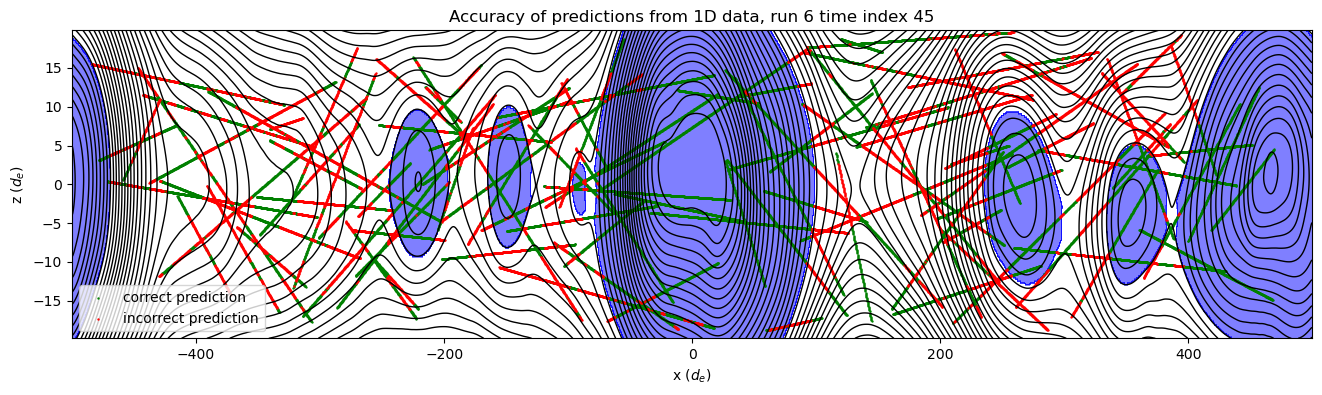

In [42]:
%matplotlib inline

flux_fn = zoomed_dset.variables['flux_fn']
plasmoids = zoomed_dset.variables['o_structures']

fig, ax = plt.subplots(figsize=(16,4))
X,Y = np.meshgrid(*flux_fn.mesh, indexing='ij')
ax.contourf(X, Y, plasmoids.data[0], alpha=0.5, cmap = matplotlib.colors.ListedColormap(['white', 'blue'])) # bdys left right auto up
ax.contour(X, Y, flux_fn.data[0], levels=50, colors='black', linewidths=1) # dashed lines mean flux_fn negative
ax.scatter(x0_right, x1_right, s=2, marker='.', color='green', label='correct prediction')
ax.scatter(x0_wrong, x1_wrong, s=2, marker='.', color='red', label='incorrect prediction')
ax.legend()
ax.set(title=f"Accuracy of predictions from 1D data, run {file_num} time index {time_idx}", xlabel=r"x ($d_e$)", ylabel=r"z ($d_e$)")
plt.show()
fig.savefig(writepath+f'/run{file_num}idx{time_idx}.svg')
plt.close(fig='all')

### Make the second figure too

In [43]:
import copy
if file_num==9 and time_idx==30:  # only make for one special boye bc we are handpicking it to showcase
    slice_num = 27 
    # redo this bc I don't think of better way rn
    s_slce = batch_subsects([s_list[slice_num]], input_length, stride)
    bx_slce = np.expand_dims(batch_subsects([bx_list[slice_num]], input_length, stride),1)
    by_slce = np.expand_dims(batch_subsects([by_list[slice_num]], input_length, stride),1)
    bz_slce = np.expand_dims(batch_subsects([bz_list[slice_num]], input_length, stride),1)
    jy_slce = np.expand_dims(batch_subsects([jy_list[slice_num]], input_length, stride),1)
    vx_slce = np.expand_dims(batch_subsects([vx_list[slice_num]], input_length, stride),1)
    x0_slce = batch_unpadded_subsects([x0_list[slice_num]], padding_length, stride)
    x1_slce = batch_unpadded_subsects([x1_list[slice_num]], padding_length, stride)
    topo_slce = np.swapaxes(batch_unpadded_subsects([topo_list[slice_num]], padding_length, stride), 1, 2)
    s_slce = torch.from_numpy(s_slce).to(device, dtype=dtype)    
    bx_slce = torch.from_numpy(bx_slce).to(device, dtype=dtype)
    by_slce = torch.from_numpy(by_slce).to(device, dtype=dtype)
    bz_slce = torch.from_numpy(bz_slce).to(device, dtype=dtype)
    jy_slce = torch.from_numpy(jy_slce).to(device, dtype=dtype)
    vx_slce = torch.from_numpy(vx_slce).to(device, dtype=dtype)
    x0_slce = torch.from_numpy(x0_slce).to(device, dtype=dtype)
    x1_slce = torch.from_numpy(x1_slce).to(device, dtype=dtype)
    topo_slce = torch.from_numpy(topo_slce).to(device, dtype=dtype)
    slce_dset = TensorDataset(s_slce, bx_slce, by_slce, bz_slce, jy_slce, vx_slce,
                                  x0_slce, x1_slce, topo_slce)
    slce_dl = DataLoader(slce_dset, batch_size = batch_size)
    #get prediction correctness
    pred_plas = []
    pred_true = []
    s_preds = []
    
    with torch.no_grad():
        for s, bx, by, bz, jy, vx, x0, x1, y in slce_dl:
            pred = model(bx, by, bz, jy, vx)
            plas = pred.argmax(1).type(torch.float).numpy().flatten()
            pred_plas.append(plas) # prediction
            pred_true.append(plas == y.argmax(1).type(torch.float).numpy().flatten())
            s_preds.append(s[:,padding_length:padding_length+stride])
    pred_true = np.concatenate(pred_true, axis=0).flatten()
    pred_plas = np.concatenate(pred_plas, axis=0).flatten()
    s_preds = np.concatenate(s_preds, axis=0).flatten()
    x0_slce = x0_slce.flatten()
    x1_slce = x1_slce.flatten()
    x0_rightz = x0_slce[pred_true]
    x1_rightz = x1_slce[pred_true]
    x0_wrongz = x0_slce[~pred_true]
    x1_wrongz = x1_slce[~pred_true]
    # chop the data to zoom in on plasmoiddddd
    slce_dset = zoomed_dset.ndslice(zooms=[[-160,20],[-15,10]])
    flux_fnz = slce_dset.variables['flux_fn']
    plasmoidsz = slce_dset.variables['o_structures']
    Xz,Yz = np.meshgrid(*flux_fnz.mesh, indexing='ij')

    # make a fancy figure
    mpl.rcParams['hatch.color']='k'
    fig = plt.figure(figsize=(10,6),layout="constrained")
    gs = GridSpec(5, 6, figure=fig)
    ax = fig.add_subplot(gs[0:2,:])
    ax.contourf(X, Y, plasmoids.data[0], alpha=0.5, cmap = matplotlib.colors.ListedColormap(['white', 'blue'])) # bdys left right auto up
    ax.contour(X, Y, flux_fn.data[0], levels=50, colors='black', linewidths=1) # dashed lines mean flux_fn negative
    ax.scatter(x0_right, x1_right, s=1, marker='.', color='green', label='correct prediction')
    ax.scatter(x0_wrong, x1_wrong, s=1, marker='.', color='red', label='incorrect prediction')
    ax.legend()
    ax.set(title=f"Accuracy of predictions from 1D data, run {file_num} time index {time_idx}", xlabel=r"x ($d_e$)", ylabel=r"z ($d_e$)")
    ax0 = fig.add_subplot(gs[2:,0:3])
    ax3 = fig.add_subplot(gs[4,3:]) # def first bc has axis label
    ax1 = fig.add_subplot(gs[2,3:],sharex=ax3)
    ax2 = fig.add_subplot(gs[3,3:],sharex=ax3)
    plt.setp(ax1.get_xticklabels(), visible=False)
    plt.setp(ax2.get_xticklabels(), visible=False)
    ax0.set(title="Predictions, one slice", xlabel=r"x ($d_e$)", ylabel=r"z ($d_e$)")
    ax1.set(title="Input values, one slice", ylabel="B (A.U.)")
    ax2.set(ylabel=r"$j_y$ (A.U.)")
    ax3.set(xlabel=r"length along slice ($d_e$)", ylabel=r"$v_x$ (A.U.)")
    #plot all the data
    ax0.contourf(Xz, Yz, plasmoidsz.data[0], alpha=0.5, cmap = matplotlib.colors.ListedColormap(['white', 'blue']))
    ax0.contour(Xz, Yz, flux_fnz.data[0], levels=30, colors='black', linewidths=1)
    scatter_right = ax0.scatter(x0_rightz.numpy(), x1_rightz.numpy(), marker='.', s=2, color='green', label='correct prediction')
    scatter_wrong = ax0.scatter(x0_wrongz.numpy(), x1_wrongz.numpy(), marker='.', s=2, color='red', label='incorrect prediction')
    scatter_start = ax0.scatter(x0_slce[0], x1_slce[0], marker='*', s=30, color='black', label='starting point')
    ax0.legend()
    ax1.plot(s_list[slice_num], bx_list[slice_num], label=r"$B_x$",linestyle='--', linewidth=1, color='black')
    ax1.plot(s_list[slice_num], by_list[slice_num], label=r"$B_y$", color='black', linewidth=0.5)
    ax1.plot(s_list[slice_num], bz_list[slice_num], label=r"$B_z$",linestyle=':', color='black', linewidth=1)
    ax1.legend()
    ax2.plot(s_list[slice_num], jy_list[slice_num],color='black', linewidth=0.5)
    ax3.plot(s_list[slice_num], vx_list[slice_num],color='black', linewidth=0.5)
    # highlight the real and predicted plasmoids
    ax1.fill_between(s_preds, 0, 1, where=pred_plas, hatch='\\\\\\',
                facecolor='yellow', alpha=1, transform=ax1.get_xaxis_transform())
    ax2.fill_between(s_preds, 0, 1, where=pred_plas, hatch='\\\\\\', label='Predicted plasmoid',
                facecolor='yellow', alpha=1, transform=ax2.get_xaxis_transform())
    ax3.fill_between(s_preds, 0, 1, where=pred_plas, hatch='\\\\\\',
                facecolor='yellow', alpha=1, transform=ax3.get_xaxis_transform())
    ax1.fill_between(s_list[slice_num], 0, 1, where=topo_list[slice_num][:,1], hatch='//',
                facecolor='blue', alpha=0.5, transform=ax1.get_xaxis_transform())
    ax2.fill_between(s_list[slice_num], 0, 1, where=topo_list[slice_num][:,1], hatch='//', label='Actual plasmoid',
                facecolor='blue', alpha=0.5, transform=ax2.get_xaxis_transform())
    ax3.fill_between(s_list[slice_num], 0, 1, where=topo_list[slice_num][:,1], hatch='//',
                facecolor='blue', alpha=0.5, transform=ax3.get_xaxis_transform())
    leg = ax2.legend()
    leg.legend_handles[0].set_edgecolor('k')
    leg.legend_handles[1].set_edgecolor(mpl.colors.to_rgba('k', 1))
    plt.show()                        
    fig.savefig(writepath+f'/run{file_num}idx{time_idx}_closeup.png', dpi=400)

#    plt.close(fig='all')

In [44]:
# 27 is index of interest